In [1]:
# To save time, start this download first, before reading through the examples.
import torch, torchvision, os
if not os.path.isfile('datasets/miniplaces/train/yard/00001000.jpg'):
    torchvision.datasets.utils.download_and_extract_archive(
        'http://dissect.csail.mit.edu/datasets/miniplaces.zip',
        'datasets', md5='bfabeb497c7eca01c74cd8441a9ac108')

100%|██████████| 491M/491M [00:17<00:00, 28.4MB/s] 


Extracting datasets/miniplaces.zip to datasets


<img src="dataloader.png" style="max-width:100%">

Datasets and Dataloaders in pytorch
===================================

Data sets can be thought of as big arrays of data.  If the data set is small enough (e.g., MNIST, which has 60,000 28x28 grayscale images), a dataset can be literally represented as an array - or more precisely, as a single pytorch tensor.  With one number per pixel, MNIST takes about 200 megabytes of RAM, which fits comfortably into a modern computer.

But larger-scale datasets like ImageNet or Places365 have more than a million higher-resolution full-color images.  In these cases, an ordinary python array or pytorch tensor would require more than a terabyte of RAM, which is impractical on most computers.

Instead, we need to load the data from disk (or SSD).  Unfortunately, the latency of loading from disk is very slow compared to RAM, so we need to do the loading cleverly if we want to load the data quickly.

To solve the problem, pytorch provides two classes:
 * `torch.utils.data.Dataset` - This very simple base class represents an array where the actual data may be slow to fetch, typically because the data is in disk files that require some loading, decoding, or other preprocessing. Pytorch provides a variety of different `Dataset` subclasses.  For example, there is a handy one called `ImageFolder` that treats a directory tree of image files as an array of classified images.
 * `torch.utils.data.DataLoader` - This fancy class wraps a `Dataset` as a stream of data batches.  Behind the scenes it uses a few techniques to feed the data faster.  You do not need to subclass `DataLoader` - its purpose is to make a `Dataset` speedy.

## Looking at an image data set using ImageFolder

The most common `Dataset` used in computer vision is `ImageFolder`, which loads a set of image files from a directory tree.  It treats every subdirectory of images as a classification category.  To demonstrate it, we will use it to load images from the miniplaces dataset loaded above.

**Directory layout.** Notice that `datasets/miniplaces/val` contains a set of 100 directories with names like `golf_course`.  Each of these directories contains 100 images, each stored as a jpeg file: 10000 images in total.

In [2]:
ls datasets/miniplaces/val/golf_course

00000090.jpg  00001620.jpg  00003665.jpg  00005143.jpg  00007278.jpg
00000139.jpg  00001654.jpg  00003671.jpg  00005266.jpg  00007405.jpg
00000375.jpg  00001696.jpg  00003764.jpg  00005493.jpg  00007445.jpg
00000565.jpg  00001747.jpg  00003790.jpg  00005608.jpg  00007666.jpg
00000637.jpg  00001797.jpg  00003829.jpg  00005777.jpg  00007746.jpg
00000650.jpg  00001948.jpg  00003837.jpg  00005793.jpg  00007987.jpg
00000694.jpg  00002048.jpg  00003848.jpg  00005814.jpg  00007988.jpg
00000711.jpg  00002050.jpg  00003949.jpg  00005902.jpg  00008145.jpg
00000780.jpg  00002055.jpg  00004343.jpg  00006123.jpg  00008290.jpg
00000793.jpg  00002104.jpg  00004393.jpg  00006155.jpg  00008310.jpg
00000948.jpg  00002116.jpg  00004454.jpg  00006246.jpg  00008581.jpg
00000977.jpg  00002211.jpg  00004495.jpg  00006282.jpg  00008653.jpg
00001067.jpg  00002278.jpg  00004514.jpg  00006295.jpg  00008765.jpg
00001089.jpg  00002297.jpg  00004583.jpg  00006323.jpg  00008798.jpg
00001138.jpg  00002382.jpg  000046

**Constructing an ImageFolder.**  Making an ImageFolder at the root directory of the data set creats an object that behaves like an array: it has a length, and each entry contains a tuple with an image and a number.  The image is stored as a `PIL` object which is a standard python object for images, and the number denotes the classification class - with one class for each folder, numbered in alphabetical order.

Length is 10000
5100th item is a pair (<PIL.Image.Image image mode=RGB size=128x128 at 0x7FCFF8177700>, 51)


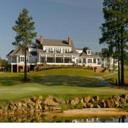

Class name is golf_course


In [3]:
val_set = torchvision.datasets.ImageFolder('datasets/miniplaces/val')
print('Length is', len(val_set))
item = val_set[5100]
print('5100th item is a pair', item)

# Display the PIL image and the class name directly.
display(item[0])
print('Class name is', val_set.classes[item[1]])

**Transforming the PIL image into a pytorch tensor.**  A PIL image is not convenient for training: we would prefer our data set to return pytorch tensors.  So we can tell `ImageFolder` to do this by specifying the `transform` function on construction.  Pytorch comes with a standard transform function `torchvision.transforms.ToTensor()` which converts an image to a pytorch tensor.

Now when indexing into the data set, we will get a pytorch tensor instead of a PIL image.

(tensor([[[0.7569, 0.7608, 0.7765,  ..., 0.6980, 0.6941, 0.7176],
         [0.7569, 0.7608, 0.7765,  ..., 0.7216, 0.7098, 0.7294],
         [0.7569, 0.7647, 0.7804,  ..., 0.7529, 0.7412, 0.7490],
         ...,
         [0.1333, 0.1569, 0.2039,  ..., 0.5176, 0.2588, 0.4902],
         [0.2549, 0.2667, 0.2941,  ..., 0.5137, 0.2824, 0.4353],
         [0.3020, 0.2980, 0.2941,  ..., 0.4745, 0.2588, 0.3569]],

        [[0.6235, 0.6275, 0.6392,  ..., 0.5922, 0.5804, 0.5961],
         [0.6235, 0.6275, 0.6392,  ..., 0.6157, 0.5961, 0.6078],
         [0.6275, 0.6353, 0.6431,  ..., 0.6471, 0.6275, 0.6275],
         ...,
         [0.0980, 0.1216, 0.1569,  ..., 0.4706, 0.2078, 0.4392],
         [0.2078, 0.2196, 0.2353,  ..., 0.4667, 0.2314, 0.3922],
         [0.2431, 0.2392, 0.2314,  ..., 0.4275, 0.2157, 0.3137]],

        [[0.5137, 0.5176, 0.5294,  ..., 0.4863, 0.4627, 0.4745],
         [0.5137, 0.5176, 0.5294,  ..., 0.5098, 0.4784, 0.4863],
         [0.5059, 0.5137, 0.5255,  ..., 0.5333, 0.5098, 0

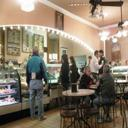

In [4]:
val_set =  torchvision.datasets.ImageFolder(
    'datasets/miniplaces/val',
    transform=torchvision.transforms.ToTensor())
print(val_set[1000])

# There is an inverse transform that can be used to convert it back to a PIL image,
# handy if we want to see it.
as_image = torchvision.transforms.ToPILImage()
display(as_image(val_set[1000][0]))

## Fast Dataset Access using DataLoader

When we use a dataset for training, we will usually run through the whole dataset in batches.  We could do this ourselves, as in line 6-8 below, by just fetching the images one at a time and grouping them.

But a faster way to iterate through the dataset is to wrap our `val_set` object in a `torch.utils.data.DataLoader` object, as shown on line 14-18 below.  The `val_loader` we get can magically pull data out of the Dataset much  faster than doing it in the smiple way; the `DataLoader` class does this by using several threads to load and prefetch the data.

The speedup will depend on the system and the number of threads you use (the number of threads to use is specified using `num_workers`).  In practice using `DataLoader` will typically be 5-20 times faster than direct `Dataset` access.

In [5]:
import time

print('Going over the data set as an array.')
start = time.time()
summed_image_dataset = 0
batch_size = 100
for i in range(0, len(val_set), batch_size):
    image_batch = torch.stack([val_set[i+j][0] for j in range(batch_size)])
    summed_image_dataset += image_batch.sum(0)
end = time.time()
print(f'Took {end - start} seconds')

print('Going over the same dataset using a dataloader.')
start = time.time()
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, num_workers=10)
summed_image_loader = 0
for image_batch, label_batch in val_loader:
    summed_image_loader += image_batch.sum(0)
end = time.time()
print(f'Took {end - start} seconds')

print('Numerical difference is exactly', (summed_image_loader - summed_image_dataset).norm().item())

Going over the data set as an array.
Took 3.5340657234191895 seconds
Going over the same dataset using a dataloader.


/home/addad222/anaconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Took 1.8480758666992188 seconds
Numerical difference is exactly 0.0


### Exercise

1. Try adjusting `num_workers` down to 1 and up to 100.  How does this affect the speed?
2. Try changing `batch_size` down to 1 or up to 1000.

**Note**: the speed differences you see will depend on the specifics of your system setup.
If you are running on Google Colab, you may not see much of a speedup from DataLoader.
This is because Colab provides a very low-latency virtual disk (so direct Dataset access
is faster than on a regular computer), and a virtual CPU with very slow concurrency
(so DataLoader multithreading is slower than normal).

In [ ]:
# TODO: copy the code above and alter:
# 1. num_workers and note the changes in speed
# 2. batch_size and note the changes in speed.

**Other common dataloader tricks.**  `DataLoader` can do a few more useful things.

 * Although a DataLoader does not put batches on the GPU directly (because of multithreading limitations), it *can* put the batch in pinned memory, which is faster to copy to the GPU later after you get it out of the DataLoader.  Make the DataLoader with `pin_memory=True` for this.
 * During training you usually do not want the batches in alphabetical order.  The DataLoader can shuffle the batches so that they are randomized, instead of sequential.  `shuffle=True` for this.

 
 

## Using a DataLoader for Training

We can put everything together by using the data from a data loader to train a classifier.

The following is a simplistic example of training an image classifier.  It uses the Adam optimizer and the ResNet-18 neural network architecture, and trains for a couple minutes, just passing once over the training set.

In [ ]:
from tqdm import tqdm

# Create a Dataset of miniplaces training images.
train_set = torchvision.datasets.ImageFolder(
    'datasets/miniplaces/train',
    torchvision.transforms.ToTensor())

# Wrap the Dataset in a high-speed DataLoader with batch_size 100.
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=100, num_workers=10,
    shuffle=True,
    pin_memory=True)

# Create an untrained neural network using the ResNet 18 architecture.
model = torchvision.models.resnet18(num_classes=100).cuda()

# Set up the model for training using the Adam optimizer.
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# To train, optimize an objective on batches of training data.
# Here we look at every training image once.
for batch in tqdm(train_loader):
    images, labels = [d.cuda() for d in batch]
    optimizer.zero_grad()
    scores = model(images.cuda())
    loss = torch.nn.functional.cross_entropy(scores, labels)
    loss.backward()
    optimizer.step()

## Checking Accuracy with a Held-Out Dataset

To check if network has learned anything useful, we can check whether the model can make good predictions on unseen images.  The easy way to do this is to create a second `ImageFolder` dataset (and `DataLoader`) with a second set of images that was **not** used for training.

While the achieved accuracy after a couple minutes of training is not perfect, it is already much better than random.

In [ ]:
# Create a validation dataset and data loader.
val_set = torchvision.datasets.ImageFolder(
    'datasets/miniplaces/val',
    torchvision.transforms.ToTensor())
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=100, num_workers=10,
    pin_memory=True)

# This function runs over the validation images and counts accurate predictions.
def accuracy():
    model.eval()
    correct = 0
    for iter, batch in enumerate(val_loader):
        images, labels = [d.cuda() for d in batch]
        with torch.no_grad():
            scores = model(images.cuda())
        correct += (scores.max(1)[1] == labels).float().sum()
    return correct.item() / len(val_set)

print(f'Accuracy on unseen images {accuracy() * 100}% (random guesses would be 1%)')

### Exercise

1. For every 10th batch, display the first image in the batch.
2. Also print the predicted class name and the true class name for that image.

Hints:
* Use the `as_image` function defined in a previous cell.
* Use `images[0].cpu()` to move the image to the CPU before displaying it.
* The prediction of the network for the 0th item of the batch is `scores.max(1)[1][0]`
* Use `val_set.classes[pred]` to convert the numerical prediction to a readable label.

## Improving Training using Data Augmentation

One of the main ways to stretch a data set to make it more effective for training is to randomly adjust the images.  For example if we randomly adjust the crop, color, or orientation of the image while loading, using the same image file multiple times will produce different training examples for the network.  This is an easy way to increase the amount of training diversity in the data set without requring more actual images.

To do data augmentation in a pytorch `Dataset`, you can specify more operations on `transform=` besides `ToTensor()`.

In particular, there is a `Compose` transform that makes it easy to chain a series of data transformations; and `torchvision.transforms` includes a number of useful image transforms such as random resized crops and image flips.

Here is an example:

In [ ]:
# Create a Dataset of miniplaces training images.
train_set = torchvision.datasets.ImageFolder(
    'datasets/miniplaces/train',
    torchvision.transforms.Compose([
        torchvision.transforms.RandomCrop(112),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
    ]))
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=100, num_workers=10,
    shuffle=True,
    pin_memory=True)

# Now let's train for one more epoch, and test the accuracy
model.train()
for batch in tqdm(train_loader):
    images, labels = [d.cuda() for d in batch]
    optimizer.zero_grad()
    scores = model(images.cuda())
    loss = torch.nn.functional.cross_entropy(scores, labels)
    loss.backward()
    optimizer.step()
print(f'Accuracy on unseen images {accuracy() * 100}% (random guesses would be 1%)')

### Exercise

1. Print out the same images as before, with updated predictions for the newly tuned network parameters.
2. Repeat training for a few more epochs.  How does the accuracy evolve?

### Epilog

Almost all the pytorch code you will find will be variations and extensions of the patterns we have covered.  You're ready to explore.

Have fun!